In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
base_path = '../../'
sys.path.append(base_path)

In [3]:
from torch import nn
import torch

"""
3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation
Paper URL: https://arxiv.org/abs/1606.06650
Author: Amir Aghdam
"""


class Conv3DBlock(nn.Module):
    """
    The basic block for double 3x3x3 convolutions in the analysis path
    -- __init__()
    :param in_channels -> number of input channels
    :param out_channels -> desired number of output channels
    :param bottleneck -> specifies the bottlneck block
    -- forward()
    :param input -> input Tensor to be convolved
    :return -> Tensor
    """

    def __init__(self, in_channels, out_channels, bottleneck=False) -> None:
        super(Conv3DBlock, self).__init__()
        self.conv1 = nn.Conv3d(
            in_channels=in_channels,
            out_channels=out_channels // 2,
            kernel_size=(3, 3, 3),
            padding=1,
        )
        self.bn1 = nn.BatchNorm3d(num_features=out_channels // 2)
        self.conv2 = nn.Conv3d(
            in_channels=out_channels // 2,
            out_channels=out_channels,
            kernel_size=(3, 3, 3),
            padding=1,
            stride=1,
        )
        self.bn2 = nn.BatchNorm3d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.bottleneck = bottleneck
        if not bottleneck:
            self.pooling = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=2)

    def forward(self, input):
        res = self.relu(self.bn1(self.conv1(input)))
        res = self.relu(self.bn2(self.conv2(res)))
        out = None
        if not self.bottleneck:
            out = self.pooling(res)
        else:
            out = res
        return out, res


class UpConv3DBlock(nn.Module):
    """
    The basic block for upsampling followed by double 3x3x3 convolutions in the synthesis path
    -- __init__()
    :param in_channels -> number of input channels
    :param out_channels -> number of residual connections' channels to be concatenated
    :param last_layer -> specifies the last output layer
    :param num_classes -> specifies the number of output channels for dispirate classes
    -- forward()
    :param input -> input Tensor
    :param residual -> residual connection to be concatenated with input
    :return -> Tensor
    """

    def __init__(
        self, in_channels, res_channels=0, last_layer=False, num_classes=None
    ) -> None:
        super(UpConv3DBlock, self).__init__()
        assert (last_layer == False and num_classes == None) or (
            last_layer == True and num_classes != None
        ), "Invalid arguments"
        self.upconv1 = nn.ConvTranspose3d(
            in_channels=in_channels,
            out_channels=in_channels,
            kernel_size=(2, 2, 2),
            stride=2,
        )
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm3d(num_features=in_channels // 2)
        self.conv1 = nn.Conv3d(
            in_channels=in_channels + res_channels,
            out_channels=in_channels // 2,
            kernel_size=(3, 3, 3),
            padding=(1, 1, 1),
        )
        self.conv2 = nn.Conv3d(
            in_channels=in_channels // 2,
            out_channels=in_channels // 2,
            kernel_size=(3, 3, 3),
            padding=(1, 1, 1),
            stride=1,
        )
        self.last_layer = last_layer
        if last_layer:
            self.conv3 = nn.Conv3d(
                in_channels=in_channels // 2,
                out_channels=num_classes,
                kernel_size=(1, 1, 1),
            )

    def forward(self, input, residual=None):
        out = self.upconv1(input)
        if residual != None:
            out = torch.cat((out, residual), 1)
        out = self.relu(self.bn(self.conv1(out)))
        out = self.relu(self.bn(self.conv2(out)))
        if self.last_layer:
            out = self.conv3(out)
        return out


class UNet3D(nn.Module):
    """
    The 3D UNet model
    -- __init__()
    :param in_channels -> number of input channels
    :param num_classes -> specifies the number of output channels or masks for different classes
    :param level_channels -> the number of channels at each level (count top-down)
    :param bottleneck_channel -> the number of bottleneck channels
    -- forward()
    :param input -> input Tensor
    :return -> Tensor
    """

    def __init__(
        self,
        in_channels,
        num_classes,
        level_channels=[64, 128, 256, 512],
    ) -> None:
        super(UNet3D, self).__init__()
        self.level_channels = level_channels
        bottleneck_channel = level_channels[-1] *2
        self.num_levels = len(level_channels)

        # Analysis path
        self.analysis_blocks = nn.ModuleList()
        for i in range(self.num_levels):
            in_ch = in_channels if i == 0 else level_channels[i-1]
            out_ch = level_channels[i]
            self.analysis_blocks.append(
                Conv3DBlock(in_channels=in_ch, out_channels=out_ch)
            )

        # Bottleneck
        self.bottleNeck = Conv3DBlock(
            in_channels=level_channels[-1], out_channels=bottleneck_channel, bottleneck=True
        )

        # Synthesis path
        self.synthesis_blocks = nn.ModuleList()
        reversed_levels = list(reversed(range(self.num_levels)))
        for idx, i in enumerate(reversed_levels):
            in_ch = bottleneck_channel if idx == 0 else level_channels[i+1]
            res_ch = level_channels[i]
            last_layer = (i == 0)
            block_kwargs = {
                "in_channels": in_ch,
                "res_channels": res_ch,
                "last_layer": last_layer,
            }
            if last_layer:
                block_kwargs["num_classes"] = num_classes
            self.synthesis_blocks.append(
                UpConv3DBlock(**block_kwargs)
            )

    def forward(self, input):
        # Analysis path forward feed
        residuals = []
        out = input
        for block in self.analysis_blocks:
            out, res = block(out)
            residuals.append(res)
        out, _ = self.bottleNeck(out)

        # Synthesis path forward feed
        for idx, block in enumerate(self.synthesis_blocks):
            res = residuals[-(idx+1)]
            out = block(out, res)
        return out

model = UNet3D(
    in_channels=1,
    num_classes=5,
    level_channels=[16, 32, 64],
)


In [ ]:
from src.pyvista_flow_field_dataset import PyvistaFlowFieldDataset
ds_pv = PyvistaFlowFieldDataset.load_from_huggingface(num_samples=10000, data_dir='datasets/pyvista')
#ds_pv= PyvistnormalizationaFlowFieldDataset.try_from_directory("datasets/pyvista",1000)
ds_pv[800].plot_volume("Pressure")

Loaded 10000 samples from 'datasets/pyvista'.


2025-05-26 07:06:24.288 (   0.695s) [    7DEBDB7AA740]      vtkCGNSReader.cxx:4268  WARN| vtkCGNSReader (0x60a3de461b30): Skipping BC_t node: BC_t type 'BCInflow' not supported yet.
2025-05-26 07:06:24.288 (   0.695s) [    7DEBDB7AA740]      vtkCGNSReader.cxx:4268  WARN| vtkCGNSReader (0x60a3de461b30): Skipping BC_t node: BC_t type 'BCSymmetryPlane' not supported yet.
2025-05-26 07:06:24.288 (   0.695s) [    7DEBDB7AA740]      vtkCGNSReader.cxx:4268  WARN| vtkCGNSReader (0x60a3de461b30): Skipping BC_t node: BC_t type 'BCTunnelOutflow' not supported yet.


Widget(value='<iframe src="http://localhost:32959/index.html?ui=P_0x7deaa0bfce50_0&reconnect=auto" class="pyvi…

Exception raised
KeyError('a33727b2dba4ff789b86c65734abf2fb_106041d')
Traceback (most recent call last):
  File "/home/olep/Documents/flow_field_dataset/.venv/lib/python3.11/site-packages/wslink/protocol.py", line 313, in onCompleteMessage
    results = func(*args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^
  File "/home/olep/Documents/flow_field_dataset/.venv/lib/python3.11/site-packages/trame_vtk/modules/vtk/protocols/local_rendering.py", line 33, in get_array
    self.context.get_cached_data_array(data_hash, binary)
  File "/home/olep/Documents/flow_field_dataset/.venv/lib/python3.11/site-packages/trame_vtk/modules/vtk/serializers/synchronization_context.py", line 35, in get_cached_data_array
    cache_obj = self.data_array_cache[p_md5]
                ~~~~~~~~~~~~~~~~~~~~~^^^^^^^
KeyError: 'a33727b2dba4ff789b86c65734abf2fb_106041d'

Exception raised
KeyError('0f5fdd87795167f39fee85b5858458a2_176791L')
Traceback (most recent call last):
  File "/home/olep/Documents/flow_field_dat

In [5]:
from src.voxel_flow_field_dataset import VoxelFlowFieldDataset, VoxelFlowFieldDatasetConfig
import torch.utils.data
ds_voxel = VoxelFlowFieldDataset('datasets/voxels',VoxelFlowFieldDatasetConfig(ds_pv, resolution=(32,16,16)))
#s_voxel = VoxelFlowFieldDataset('datasets/voxels')
ds_voxel.normalize()

Voxelizing samples: 100%|██████████| 10000/10000 [00:01<00:00, 9105.71it/s]


In [6]:
num_train_samples = int(len(ds_voxel) * 0.8)
num_val_samples = len(ds_voxel) - num_train_samples
ds_voxel.shuffle()
train_dataset = ds_voxel[:num_train_samples]
val_dataset = ds_voxel[num_train_samples:]

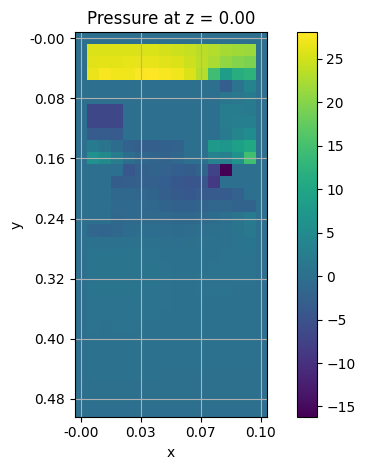

In [198]:
val_dataset[0].plot_slice("Pressure",slice_idx=3)

In [8]:

import torch.utils.data as data
train_dataloader = data.DataLoader(train_dataset.get_default_loadable_dataset(), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
val_dataloader = data.DataLoader(val_dataset.get_default_loadable_dataset(), batch_size=128, shuffle=False, num_workers=0, pin_memory=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
len(train_dataset), len(val_dataset)

(8000, 2000)

In [9]:
next(iter(train_dataloader))[0].shape

torch.Size([128, 32, 16, 16])

Using device: cuda
Epoch 0/200, Loss: 3.6134869200842723, Val Loss: 3.164834603667259
Epoch 0/200, Loss: 3.560906453738137
Epoch 1/200, Loss: 3.1954583345897616
Epoch 2/200, Loss: 3.019903374096704
Epoch 3/200, Loss: 2.9105865255234735
Epoch 4/200, Loss: 2.8327623132675415
Epoch 5/200, Loss: 2.758321143331982
Epoch 6/200, Loss: 2.714306408450717
Epoch 7/200, Loss: 2.674267876715887
Epoch 8/200, Loss: 2.7187785487326366
Epoch 9/200, Loss: 2.602241871848939
Epoch 10/200, Loss: 2.9841583191402377, Val Loss: 2.926117055118084
Epoch 10/200, Loss: 2.498798482001774
Epoch 11/200, Loss: 2.490558375441839
Epoch 12/200, Loss: 2.444765734294104
Epoch 13/200, Loss: 2.4577250140053883
Epoch 14/200, Loss: 2.5063747971776933
Epoch 15/200, Loss: 2.3990036192394437
Epoch 16/200, Loss: 2.413437005073305
Epoch 17/200, Loss: 2.302029623871758
Epoch 18/200, Loss: 2.3449802531136408
Epoch 19/200, Loss: 2.2592798812048778
Epoch 20/200, Loss: 2.7207383466145347, Val Loss: 2.881507121026516
Epoch 20/200, Loss:

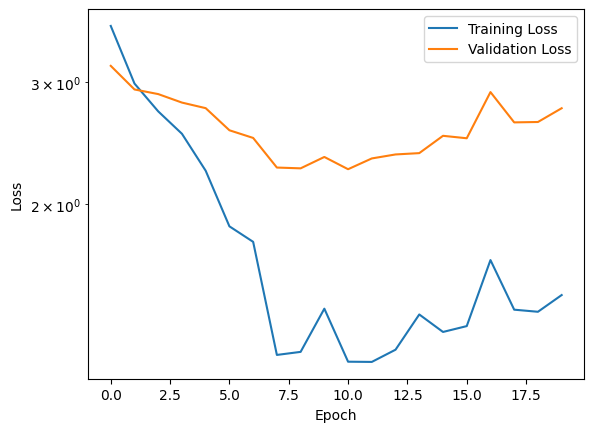

In [10]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
print(f"Using device: {device}")
model.to(device)
criterion = nn.MSELoss()
lr=2e-5
epochs=200
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

training_losses = []
validation_losses = []

    
for epoch in range(epochs):
    if (epoch) % 10 == 0:
        val_loss = 0
        train_loss_in_eval = 0
        model.eval()
        with torch.no_grad():
            for x, y in val_dataloader:
                x, y = x.to(device), y.to(device)
                x = x.float().unsqueeze(-1)
                x = x.permute(0, 4, 1, 2, 3)
                y = y.permute(0, 4, 1, 2, 3)
                outputs = model(x)
                loss = criterion(outputs, y)
                val_loss += loss.item()
            for x, y in train_dataloader:
                x, y = x.to(device), y.to(device)
                x = x.float().unsqueeze(-1)
                x = x.permute(0, 4, 1, 2, 3)
                y = y.permute(0, 4, 1, 2, 3)
                outputs = model(x)
                loss = criterion(outputs, y)
                train_loss_in_eval += loss.item()


        print(f"Epoch {epoch}/{epochs}, Loss: {train_loss_in_eval / len(train_dataloader)}, Val Loss: {val_loss / len(val_dataloader)}")
        training_losses.append(train_loss_in_eval / len(train_dataloader))
        validation_losses.append(val_loss / len(val_dataloader))
    model.train()
    epoch_loss = 0
    for x,y in train_dataloader:
        x, y = x.to(device), y.to(device)
        x=x.float().unsqueeze(-1)
        x = x.permute(0, 4, 1, 2, 3)  # (N, D, H, W, C) → (N, C, D, H, W)
        y = y.permute(0, 4, 1, 2, 3)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch}/{epochs}, Loss: {epoch_loss / len(train_dataloader)}")
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()
# Save the model
torch.save(model.state_dict(), 'unet3d.pth')

In [13]:
model.load_state_dict(torch.load('unet3d.pth', map_location=device))
model.to(device)
model.eval()

UNet3D(
  (analysis_blocks): ModuleList(
    (0): Conv3DBlock(
      (conv1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (pooling): MaxPool3d(kernel_size=(2, 2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Conv3DBlock(
      (conv1): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (pooling): MaxPool3d(kernel_size=

In [242]:
mask,y = next(iter(train_dataloader))
mask = mask.to(device)
y = y.to(device)

In [243]:
x=mask.float().unsqueeze(-1)
x = x.permute(0, 4, 1, 2, 3)  # (N, D, H, W, C) → (N, C, D, H, W)
#y = y.permute(0, 4, 1, 2, 3)
y_pred = model(x)
y_pred = y_pred.permute(0, 2, 3, 4, 1)  # (N, C, D, H, W) → (N, D, H, W, C)


In [244]:
y.mean()

tensor(0.0104, device='cuda:0')

In [245]:
y_pred.mean()

tensor(-0.0105, device='cuda:0', grad_fn=<MeanBackward0>)

In [246]:
pred_sample = ds_voxel.prediction_to_sample(mask[0], y_pred[0])

In [247]:
pred_sample.get_field("Pressure").mean()

tensor(-0.0820)

In [248]:
pred_sample.plot("Pressure")

Widget(value='<iframe src="http://localhost:32959/index.html?ui=P_0x7de79c29af10_39&reconnect=auto" class="pyv…

In [249]:
true_sample = ds_voxel.prediction_to_sample(mask[0], y[0])
true_sample.plot("Pressure")

Widget(value='<iframe src="http://localhost:32959/index.html?ui=P_0x7de5846ae710_40&reconnect=auto" class="pyv…

In [250]:
true_sample.get_field("Pressure").mean(), pred_sample.get_field("Pressure").mean()

(tensor(0.0993), tensor(-0.0820))

In [251]:
pred_sample.data["Pressure"].std()

tensor(17.8941)

In [252]:
pred_sample.plot_slice_interactively("Pressure",axis="z")

interactive(children=(IntSlider(value=8, description='slice_idx', max=15), Output()), _dom_classes=('widget-in…

In [253]:
true_sample.data["Pressure"].min()

tensor(-59.0414)

In [254]:
true_sample.plot_slice_interactively("Pressure", axis="z")

interactive(children=(IntSlider(value=8, description='slice_idx', max=15), Output()), _dom_classes=('widget-in…